In [20]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [8]:
num_loc = 20

_path = "/home/jakhremchik/Documents/RECONSTRUCT/Moscow_pilot"
dataset = Path(_path)
# dataset = Path('/home/jakhremchik/Downloads/Lenin_reconstruct')
images = dataset / 'images/'

outputs = Path('{}/outputs/sfm/'.format(_path))
sfm_pairs = outputs / 'pairs-exhaustive.txt'  # exhaustive matching
sfm_dir = outputs / 'sfm_superpoint+superglue'
loc_pairs = outputs / f'pairs-query-netvlad{num_loc}.txt'
# sfm_dir = outputs / 'sfm_d2n_NN'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

features = feature_conf['output']
feature_file = f"{features}.h5"
match_file = f"{features}_{matcher_conf['output']}_{sfm_pairs.stem}.h5"

In [9]:
global_feature_conf = extract_features.confs['netvlad']

In [5]:
pairs_from_retrieval.main(
    global_descriptors, loc_pairs, num_loc,
    query_prefix=CONDITIONS, db_model=sfm_dir)

NameError: name 'pairs_from_retrieval' is not defined

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data, and refined with SfM.

In [ ]:
%%bash -s "$dataset"
wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1
unzip $1/South-Building.zip -d $1

## Extract local features

In [11]:
extract_features.main(feature_conf, images, outputs)

[12/02/2021 22:17:29 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[12/02/2021 22:17:29 INFO] Found 810 images in root /home/jakhremchik/Documents/RECONSTRUCT/Moscow_pilot/images.
[12/02/2021 22:17:30 INFO] Skipping the extraction.


PosixPath('/home/jakhremchik/Documents/RECONSTRUCT/Moscow_pilot/outputs/sfm/feats-superpoint-n4096-r1024.h5')

## Extract gloabl features

In [12]:
global_descriptors = extract_features.main(global_feature_conf, images, outputs)

[12/02/2021 22:17:35 INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[12/02/2021 22:17:35 INFO] Found 810 images in root /home/jakhremchik/Documents/RECONSTRUCT/Moscow_pilot/images.


100%|██████████| 810/810 [02:46<00:00,  4.87it/s]

[12/02/2021 22:20:26 INFO] Finished exporting features.


In [15]:
loc_pairs

PosixPath('/home/jakhremchik/Documents/RECONSTRUCT/Moscow_pilot/outputs/sfm/pairs-query-netvlad20.txt')

In [18]:
pairs_from_retrieval.main(
    global_descriptors, loc_pairs, num_loc)

[12/02/2021 22:47:35 INFO] Extracting image pairs from a retrieval database.


ValueError: Provide either prefixes of names, a list of images, or a path to list file.

## Exhaustive matching
Since the dataset is small, we can match all $\frac{n(n-1)}{2}$ images pairs. To do so, we pass the argument `exhaustive=True` and make sure that the pair file does not exist yet. If your dataset is larger, exhaustive matching might take a long time - consider selecting fewer pairs using image retrieval and `hloc/pairs_from_retrieval.py`.

In [21]:
match_features.main(matcher_conf, sfm_pairs, features, outputs, exhaustive=True)

[12/03/2021 00:07:59 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[12/03/2021 00:08:00 INFO] Writing exhaustive match pairs to /home/jakhremchik/Documents/RECONSTRUCT/Moscow_pilot/outputs/sfm/pairs-exhaustive.txt.
Loaded SuperGlue model ("outdoor" weights)


 30%|███       | 98498/327645 [14:03:04<32:41:19,  1.95it/s]


KeyboardInterrupt: 

## SfM reconstruction
Run COLMAP on the features and matches.

In [6]:
reconstruction.main(
    sfm_dir,
    images,
    sfm_pairs,
    outputs / feature_file,
    outputs / match_file)

[11/24/2021 16:19:21 INFO] Creating an empty database...
[11/24/2021 16:19:21 INFO] Importing images into the database...
[11/24/2021 16:19:32 INFO] Importing features into the database...


100%|██████████| 108/108 [00:00<00:00, 2660.06it/s]

[11/24/2021 16:19:32 INFO] Importing matches into the database...



100%|██████████| 5778/5778 [00:02<00:00, 2866.88it/s]


[11/24/2021 16:19:34 INFO] Performing geometric verification of the matches...
[11/24/2021 16:21:15 INFO] Running the 3D reconstruction...
[11/24/2021 16:21:15 INFO] colmap mapper --database_path /home/jakhremchik/Documents/RECONSTRUCT/Statuet_5/outputs/sfm/sfm_superpoint+superglue/database.db --image_path /home/jakhremchik/Documents/RECONSTRUCT/Statuet_5/images --output_path /home/jakhremchik/Documents/RECONSTRUCT/Statuet_5/outputs/sfm/sfm_superpoint+superglue/models --Mapper.num_threads 8
[11/24/2021 16:25:05 INFO] Reconstructed 1 models.
[11/24/2021 16:25:05 INFO] Largest model is #0 with {largest_model_num_images} images.
[11/24/2021 16:25:06 INFO] Statistics:
{'mean_reproj_error': 1.502895,
 'mean_track_length': 4.417866,
 'num_input_images': 108,
 'num_observations': 125569,
 'num_observations_per_image': 1162.675926,
 'num_reg_images': 108,
 'num_sparse_points': 28423}


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

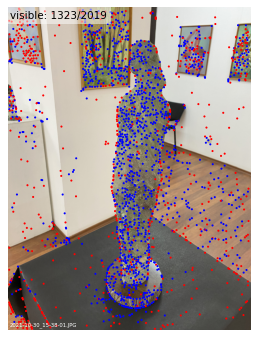

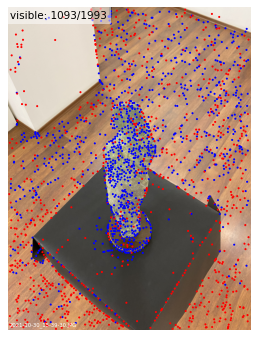

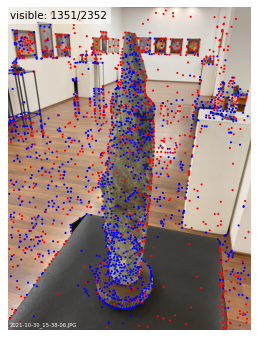

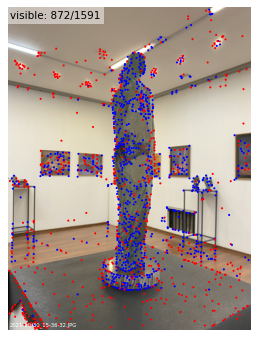

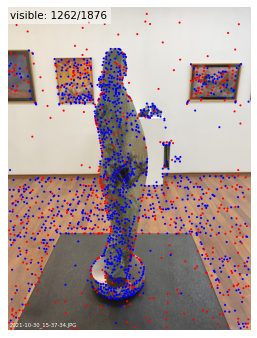

In [7]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='visibility', n=5)

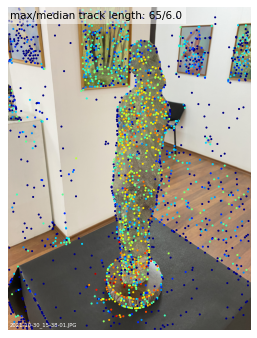

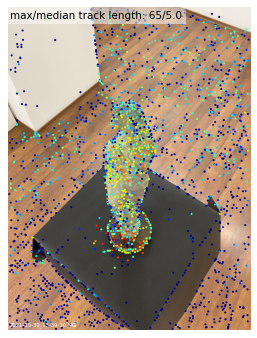

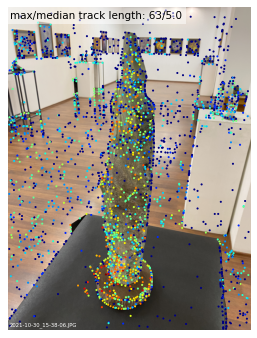

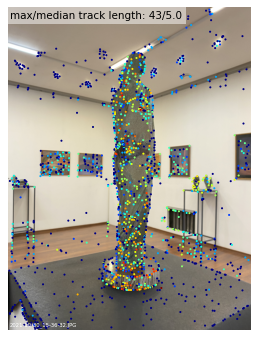

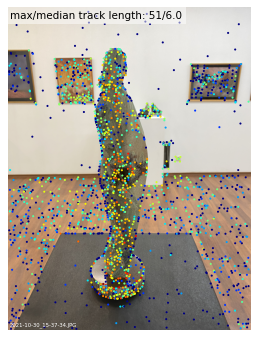

In [8]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='track_length', n=5)

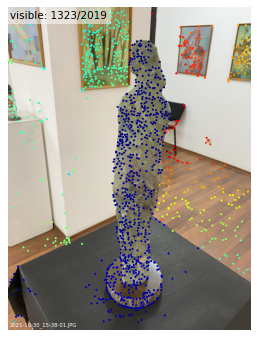

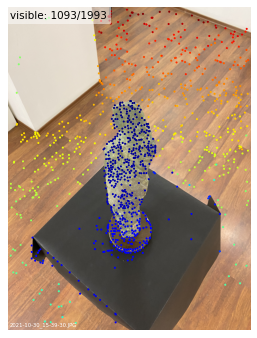

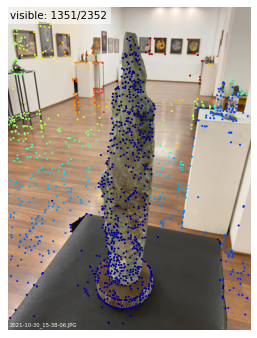

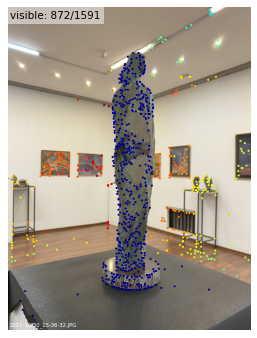

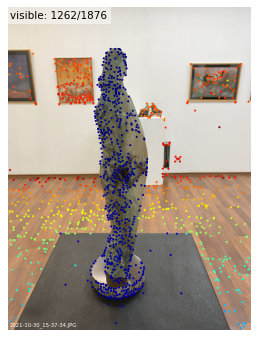

In [9]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='depth', n=5)